# Метод анализа главных компонент (Principal Component Analysis, PCA)

PCA предназначен для сокращения количества хранимых данных. Предположим, что мы хотим обучить свою модель на данных, в которых есть 200 признаков. Какие-то из этих признаков являются существенными, а какие-то нет. Мы, кончено, можем проанализировать распределение значений в различных признаках, применить эвристическую оценку и т.д., но как гарантированно получить подпространство заданной размерности с наименьшей потерей информации? На этот вопрос как раз и отвечает алгоритм PCA. По сути своей он позволяет построить проецирующий оператор на подпространство заданной размерности, при котором потеря данных будет наименьшей.

Алгоритм:

- Стандартизация исходных данных

- Вычисление матрицы ковариации на стандартизированных данных

- Вычисление собственных векторов матрицы ковариации

- Выборка n собственных векторов, отвечающих наибольшим собственным значениям, где n - размерность результирующего подпространтва

- Получение матрицы проекции на подпространство, базисными векторами которого являются векторы из предыдущего шага

Результатом имеем оператор проецирования, который позволяет преобразовывать все входящие данные, уменьшая таким образом их размерность.

## Стандартизация исходных данных

Вернемся к задаче про вина:

In [15]:
from sklearn.datasets import load_wine

wine_dataset = load_wine()

# сразу разделим данные на обучающую и тестовую выборки:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(wine_dataset['data'], wine_dataset['target'], random_state=15)

Для того, чтобы стандартизация наши данные, необходимо по каждому признаку (столбцу) вычислить медиану и дисперсию. Затем вычитаем медиану из каждого признака и делим его на дисперсию (для каждого столбца медиана и дисперсия своя):

In [16]:
# axis = 0 указывает, что вычислять нужно по столбцам

μ = X_train.mean(axis=0)
σ = X_train.std(axis=0)

X_train_normalized = (X_train - μ) / σ

# также есть готовый метод
from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train)

print(X_train_normalized == X_scaled)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


## Вычисление матрицы ковариации на стандартизированных данных

Матрица ковариации - это матрица, составленная из попарных ковариаций элементов одного или двух случайных векторов. В нашем случае элементами являются столбцы с признаками, а сама матрица ковариации характеризует связанность этих признаков.

Для вычисления матрицы ковариации воспользуемся методом numpy.cov

In [17]:
import numpy
M_cov = numpy.cov(X_train_normalized.T)

## Вычисление собственных векторов матрицы ковариации

Для вычисления собственных значений и отвечающих им собственных векторов воспользуемся готовым вызовом numpy.linalg.eig:

In [18]:
eigen_values, eigen_vectors = numpy.linalg.eig(M_cov)

## Выборка n собственных векторов, отвечающих наибольшим собственным значениям

Сначала упорядочим собственные векторы в порядке невозростания соотвествующих собственных значений:

In [19]:
idx = numpy.argsort(eigen_values)
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

Теперь нам нужно сделать выборку n векторов с наибольшими собственными значениями и составить из них матрицу с базисом подпространства:

In [20]:
n = 2

B = eigen_vectors[:n]

## Получения матрицы проецирования

Проекция вектора/матрицы x на матрицу с базисом M получается следующим образом:

In [21]:
def projection(M, x):
    return ((numpy.linalg.inv(M @ M.T) @ M) @ x.T).T

Теперь получим функцию, которая возвращает проекцию заданного вектора x при условии, что базис подпространства B:

In [22]:
from functools import partial

π = partial(projection, B)

def get_new_data(mu, sigma, project, x):
    return project((x - mu) / sigma)

process = partial(get_new_data, μ, σ, π)

## Применение полученной матрицы проекции

Теперь преобразуем наши данные в соответсвии с функцией process

In [23]:
import pandas as pd
X_train_processed = process(X_train)
X_test_processed = process(X_test)

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e4, solver='lbfgs', multi_class='multinomial', max_iter=10000)
result = logreg.fit(X_train_processed, y_train)

print("Точность на тестовом наборе: {:.2f}".format(logreg.score(X_test_processed, y_test)))

Точность на тестовом наборе: 0.71


Как видно, точность упала, но это связано с тем, что условие максимальной вариации не гарантирует нам хорошей разделимости линейными классификаторами. Визуализируем результат:

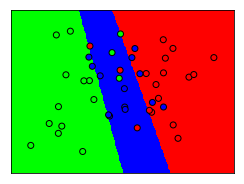

In [24]:
import numpy as np
import matplotlib.pyplot as plt

X = X_test_processed
Y = y_test

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.brg)

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.brg)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

Также есть встроенный метод для PCA:

In [25]:
from sklearn import decomposition

PCA = decomposition.PCA(n_components=n)
X_tr = PCA.fit_transform(X_train)
X_ts = PCA.transform(X_test)
logreg = LogisticRegression(C=1e4, solver='lbfgs', multi_class='multinomial', max_iter=10000)
result = logreg.fit(X_tr, y_train)

print("Точность на тестовом наборе: {:.2f}".format(logreg.score(X_ts, y_test)))

Точность на тестовом наборе: 0.64
